# KNN Classifier

### Import Packages

In [1]:
import cv2
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.decomposition import PCA
from scipy.ndimage import convolve
from scipy.signal import find_peaks
from scipy import fft
import warnings
warnings.filterwarnings('ignore')

### Global Variables

In [2]:
random_state: int = 111
image_height: int  = 256
image_width: int = 256
data_directory: str = 'data'

# True balances dataset to 10k of each class, false uses 20k generated images and 10k real images
balance_dataset_TF: bool = True 

### Define Helper Functions

In [3]:
def load_dataset(dataset_dir):
    '''
    Loads and preprocesses image dataset. 
    Adjust preprocessing steps here and the preprocess_image function.
    Requires only the image path. 

    Returns two arrays of the images and the labels. 
    '''
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    
    for ii, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = cv2.imread(image_path)  # Load image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Make grayscale
            image = cv2.resize(image, (image_height, image_width))  # Resize
            image = exposure.equalize_hist(image) # Histogram equalization
            images.append(image)
            labels.append(ii)  # Assign a label to the image based on the class index
    
    return np.array(images), np.array(labels)

def extract_hog_features(images):
    '''
    Runs the hog() method from Scikit-Image on the dataset.
    Assumes images will be grayscale as channel_axis = None by default.'

    Returns an array of image features and an array of the images.
    '''
    hog_features = []
    hog_images = []
    for img in images:
        feature_vector, image = hog(img, orientations = 8, pixels_per_cell = (8, 8),
                 cells_per_block = (1, 1), visualize = True, feature_vector = True)
        hog_features.append(feature_vector)
        hog_images.append(image)
    return np.array(hog_features), np.array(hog_images)

def extract_glcm_features(images):
    '''
    Runs the graycomatrix() and graycoprops() methods from Scikit-Image on the dataset.
    Assumes images will be grayscale. 

    Returns an array of four image features derived from the GLCM Matrix of each image.
    '''
    glcm_features = []
    for img in images:
        img = np.uint8(img * 255) # graycomatrix only accepts ints 
        # Calculate the GLCM Matrix
        glcm_matrix = graycomatrix(img, distances = [5], angles = [0], levels = 256, symmetric = True, normed = True)

        # Derive the Properties of the Matrix
        contrast = graycoprops(glcm_matrix, 'contrast')[0, 0]
        correlation = graycoprops(glcm_matrix, 'correlation')[0, 0]
        energy = graycoprops(glcm_matrix, 'energy')[0, 0]
        homogeneity = graycoprops(glcm_matrix, 'homogeneity')[0, 0]

        glcm_features.append([contrast, correlation, energy, homogeneity])
    
    return np.array(glcm_features)

def extract_spectral_features(images):
    '''
    Replicates the feature extraction process from Bammey (2023).
    Assumes images will be grayscale.

    The process finds the edges of an image through Cross Difference calculations.
    Then a Fast Fourier Transform is applied to process the signal in the frequency domain.
    Finally, the paper proposes using Peak Magnitude Extraction to identify important features.

    Returns an Peak Magnitudes of images.
    '''
    spectral_features = []
    cross_difference_filter = np.array([[-1, -1, -1],
                                        [-1, 9, -1],
                                        [-1, -1, -1]])

    for ii in range(len(images)):
        image = images[ii]
        cross_difference = convolve(image, cross_difference_filter) # Cross Difference using defined filter
        fft_image = fft.fft2(cross_difference) # FFT on the Cross Difference
        peak_magnitude_spectrum = np.abs(fft_image) # Take Absolute Value to find largest peaks
        peaks, properties = find_peaks(peak_magnitude_spectrum.flatten(), height = 0)
        peak_magnitudes = peak_magnitude_spectrum.flatten()[peaks]

        spectral_features.append(peak_magnitudes)

    # Number of peaks will vary, so need to pad smaller feature sets
    max_length = max(len(feature) for feature in spectral_features)

    padded_features = [np.pad(feature, (0, max_length - len(feature)), mode = 'constant') for feature in spectral_features]

    return np.array(padded_features)

def preprocess_image(image_path):
    '''
    Loads and preprocesses a single image for classification.
    Requires only the image path.
    '''
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Make grayscale
    image = cv2.resize(image, (image_height, image_width)) # Resize
    image = exposure.equalize_hist(image) # Histogram equalization
    features = extract_spectral_features([image])
    return features

def return_image_class(class_number):
    if class_number == 0:
        return "AI Generated"
    else:
        return "Real"

def balance_dataset(balance_dataset_TF, images, labels):
    ''' 
    Optional: Randomly under sample majority class (AI-generated) for more balaanced dataset
    Uses a random state from the global variable random_state.
    Change balance_dataset_TF to True for balanced or False for imbalanced. 

    Returns either a balanced 50/50 dataset or the original 2/3 fake, 1/3 real dataset as arrays. 
    '''
    if balance_dataset_TF == True:
        indicies_of_majority_class = [x for x, label in enumerate(labels) if label == 0]
        random.seed(random_state) # Set seed for reproducibility
        random_indicies = random.sample(indicies_of_majority_class, 10000) # Randomly select 10000 fake images
        random_undersampled_images = [images[index] for index in random_indicies]
        random_undersampled_labels = [labels[index] for index in random_indicies]
        
        #Add back real images to randomly selected generated images
        balanced_image_data = random_undersampled_images + [images[index] for index, label in enumerate(labels) if label == 1]
        balanced_label_data = random_undersampled_labels + [label for label in labels if label == 1]
        return np.array(balanced_image_data), np.array(balanced_label_data)
    
    elif balance_dataset_TF == False:
        return np.array(images), np.array(labels)
    
def create_roc_auc_graph(y_test_list, X_test_list, model_list, names_list):
    plt.figure(figsize = (8, 4))
    color_list = ['blue', '#1b9e77', '#7570b3']
    
    for ii in range(len(model_list)):
        y_score = model_list[ii].predict_proba(X_test_list[ii])[:,1]
        fpr, tpr, thresholds = roc_curve(y_test_list[ii], y_score)
        roc_auc = roc_auc_score(y_test_list[ii], y_score)
        plt.plot(fpr, tpr, color = color_list[ii], lw = 2, label = f'{names_list[ii]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color = 'orange', linestyle = '--', label = 'Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc = 'lower right')
    plt.show()

### Load Data

In [4]:
images, labels = load_dataset(data_directory)
images, labels = balance_dataset(balance_dataset_TF, images, labels)
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (20000, 256, 256)
Labels shape: (20000,)


In [5]:
print(f'Number of Generated Images: {labels[labels == 0].shape[0]}')
print(f'Number of Real Images: {labels[labels == 1].shape[0]}')

Number of Generated Images: 10000
Number of Real Images: 10000


### Extract Features

In [6]:
# Preprocess the images and extract features (Using HOG)
hog_features, hog_images = extract_hog_features(images)

In [7]:
# Preprocess the images and extract features (Using GLCM)
glcm_features = extract_glcm_features(images)

In [8]:
# Preprocess the images and extract features (Using Spectral Analysis)
# **Best Performing Festure Set**
spectral_features = extract_spectral_features(images)

### Examples of Extracted Features

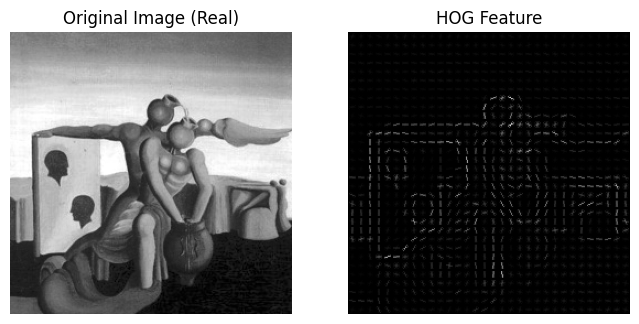

In [9]:
which_image_to_display = 17000
class_for_display = return_image_class(labels[which_image_to_display])
untransformed_image = images[which_image_to_display]
hog_image = exposure.rescale_intensity(hog_images[which_image_to_display], in_range=(0, 10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex = True, sharey = True)
ax1.axis('off')
ax1.imshow(untransformed_image, cmap=plt.cm.gray)
ax1.set_title(f'Original Image ({class_for_display})')

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('HOG Feature')
plt.show()

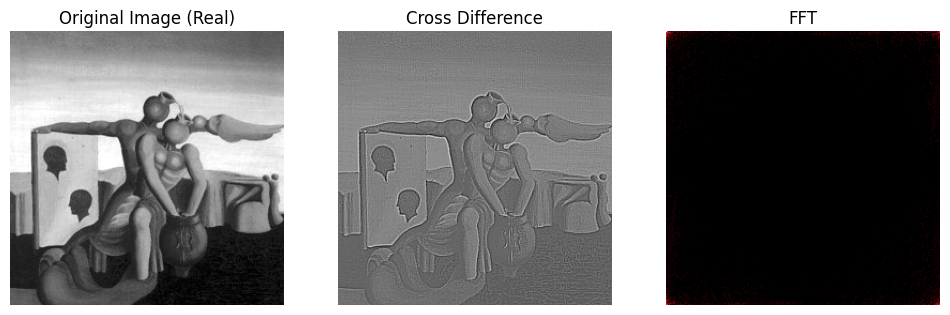

In [10]:
# Spectral Exmaple
which_image_to_display = 17000
class_for_display = return_image_class(labels[which_image_to_display])
untransformed_image = images[which_image_to_display]

cross_difference_filter = np.array([[-1, -1, -1],
                                    [-1, 9, -1],
                                    [-1, -1, -1]])

cross_difference = convolve(untransformed_image, cross_difference_filter)
fft_image = fft.fft2(cross_difference) 
peak_magnitude_spectrum = np.abs(fft_image)
peaks, properties = find_peaks(peak_magnitude_spectrum.flatten(), height = 0)
peak_magnitudes = peak_magnitude_spectrum.flatten()[peaks]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12), sharex = False, sharey = False)
ax1.axis('off')
ax1.imshow(untransformed_image, cmap=plt.cm.gray)
ax1.set_title(f'Original Image ({class_for_display})')

ax2.axis('off')
ax2.imshow(cross_difference, cmap=plt.cm.gray)
ax2.set_title('Cross Difference')

ax3.axis('off')
ax3.imshow(peak_magnitude_spectrum, cmap='gist_stern')
ax3.set_title('FFT')

plt.show()

### HOG Model Training

In [11]:
# Run this cell for HOG Features
from sklearn.utils.class_weight import compute_class_weight

# Split the dataset into training and testing sets
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(hog_features, labels, test_size = 0.3, random_state = random_state)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train_hog), y = y_train_hog)
print(f'Class Weights: {class_weights}')

# Train the KNN model
hog_model = KNeighborsClassifier(weights='distance')
hog_model.fit(X_train_hog, y_train_hog)

# Evaluate the model
y_pred_hog = hog_model.predict(X_test_hog)

Class Weights: [0.99871594 1.00128737]


### GLCM Model Training

In [12]:
# Run this cell for GLCM Features

# Split the dataset into training and testing sets
X_train_glcm, X_test_glcm, y_train_glcm, y_test_glcm = train_test_split(glcm_features, labels, test_size = 0.3, random_state = random_state)

# Train the KNN model
glcm_model = KNeighborsClassifier(weights='distance')
glcm_model.fit(X_train_glcm, y_train_glcm)

# Evaluate the model
y_pred_glcm = glcm_model.predict(X_test_glcm)

### Spectral Analysis Model Training

In [13]:
# Run this cell for Spectral Analysis

# Split the dataset into training and testing sets
X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(spectral_features, labels, test_size = 0.3, random_state = random_state)

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_sa)
X_test_pca = pca.transform(X_test_sa)

# Train the SVM model
spectral_model = KNeighborsClassifier()
spectral_model.fit(X_train_pca, y_train_sa)

# Evaluate the model
y_pred_sa = spectral_model.predict(X_test_pca)

## Assessment Metrics

In [14]:
accuracy_hog = accuracy_score(y_test_hog, y_pred_hog)
precision_hog = precision_score(y_test_hog, y_pred_hog)
recall_hog = recall_score(y_test_hog, y_pred_hog)
f1_hog = f1_score(y_test_hog, y_pred_hog)

accuracy_glcm = accuracy_score(y_test_glcm, y_pred_glcm)
precision_glcm = precision_score(y_test_glcm, y_pred_glcm)
recall_glcm = recall_score(y_test_glcm, y_pred_glcm)
f1_glcm = f1_score(y_test_glcm, y_pred_glcm)

accuracy_sa = accuracy_score(y_test_sa, y_pred_sa)
precision_sa = precision_score(y_test_sa, y_pred_sa)
recall_sa = recall_score(y_test_sa, y_pred_sa)
f1_sa = f1_score(y_test_sa, y_pred_sa)

print(f"HOG - Accuracy: {accuracy_hog:.2f}, Precision: {precision_hog:.2f}, Recall: {recall_hog:.2f}, F1 Score: {f1_hog:.2f} \n")
print(f"GLCM - Accuracy: {accuracy_glcm:.2f}, Precision: {precision_glcm:.2f}, Recall: {recall_glcm:.2f}, F1 Score: {f1_glcm:.2f} \n")
print(f"Spectral Analysis - Accuracy: {accuracy_sa:.2f}, Precision: {precision_sa:.2f}, Recall: {recall_sa:.2f}, F1 Score: {f1_sa:.2f}")

HOG - Accuracy: 0.52, Precision: 0.55, Recall: 0.20, F1 Score: 0.29 

GLCM - Accuracy: 0.52, Precision: 0.52, Recall: 0.50, F1 Score: 0.51 

Spectral Analysis - Accuracy: 0.75, Precision: 0.75, Recall: 0.74, F1 Score: 0.75


### Confusion Matrix

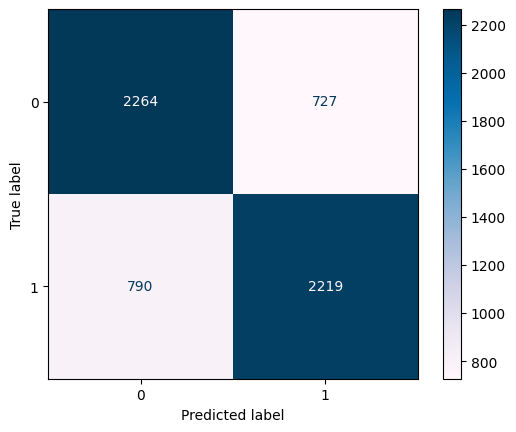

In [15]:
conf_matrix = confusion_matrix(y_test_sa, y_pred_sa, labels = spectral_model.classes_)

display_matrix = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = spectral_model.classes_).plot(cmap = 'PuBu')

plt.show()

In [16]:
print(classification_report(y_test_sa, y_pred_sa))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      2991
           1       0.75      0.74      0.75      3009

    accuracy                           0.75      6000
   macro avg       0.75      0.75      0.75      6000
weighted avg       0.75      0.75      0.75      6000



### ROC-AUC Graph

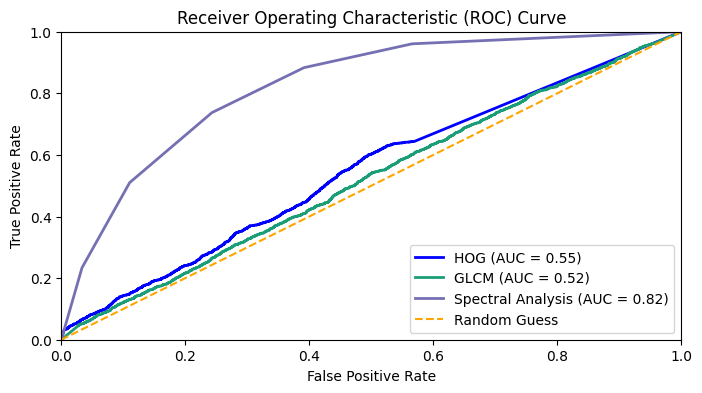

In [17]:
y_test_list = [y_test_hog, y_test_glcm, y_test_sa]
X_test_list = [X_test_hog, X_test_glcm, X_test_pca]
model_list = [hog_model, glcm_model, spectral_model]
names_list = ['HOG', 'GLCM', 'Spectral Analysis']

create_roc_auc_graph(y_test_list, X_test_list, model_list, names_list)

### Hyperparameter Tuning

In [18]:
params = {
    "n_neighbors": [1, 2, 3, 4, 5, 10, 25, 50], #Number of neighbors, 5 is default
    "weights": ["distance", "uniform"], #Uniform is default
}

# setup the grid search
grid_search = GridSearchCV(spectral_model,
                           param_grid=params,
                           cv=5,
                           verbose=1,
                           n_jobs=-1,
                           return_train_score=True)

grid_search.fit(X_train_pca, y_train_sa)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 50],
                         'weights': ['distance', 'uniform']},
             return_train_score=True, verbose=1)

In [19]:
# Making a nice table for the Grid Search
import pandas as pd

results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
50_distance,"{'n_neighbors': 50, 'weights': 'distance'}",1,0.758357,0.008773
50_uniform,"{'n_neighbors': 50, 'weights': 'uniform'}",2,0.757357,0.009003
25_distance,"{'n_neighbors': 25, 'weights': 'distance'}",3,0.756929,0.005595
25_uniform,"{'n_neighbors': 25, 'weights': 'uniform'}",4,0.756571,0.005686
10_distance,"{'n_neighbors': 10, 'weights': 'distance'}",5,0.754286,0.006896
10_uniform,"{'n_neighbors': 10, 'weights': 'uniform'}",6,0.747214,0.005991
5_uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",7,0.747000,0.006110
5_distance,"{'n_neighbors': 5, 'weights': 'distance'}",8,0.746929,0.006004
4_distance,"{'n_neighbors': 4, 'weights': 'distance'}",9,0.738929,0.006955


Accuracy: 0.77
Precision: 0.76
Recall: 0.79
F1 Score: 0.77


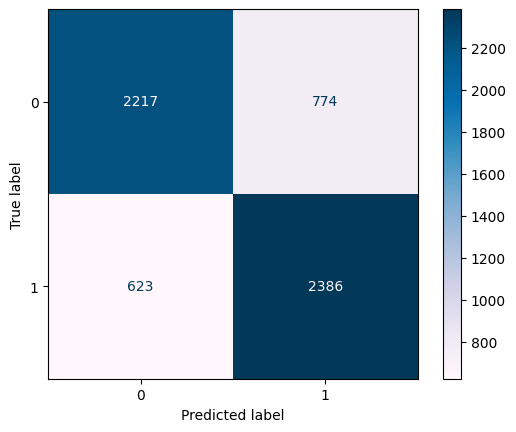

In [20]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spectral_features, labels, test_size = 0.3, random_state = random_state)

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors = 50, weights = 'distance')
knn_model.fit(X_train_pca, y_train)

# Evaluate the model performance
y_pred = knn_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred, labels = knn_model.classes_)

display_matrix = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = knn_model.classes_).plot(cmap = 'PuBu')

plt.show()

### Save the Model
Saving the Spectral Analysis Model as it was the best performing for KNN.

Note that the PCA fitted model also would need to be saved off and loaded for another application.

In [21]:
from joblib import dump, load

model_to_save = dump(knn_model, filename = 'models/ModelKNN.sav')

### Reloading Model and Making a Prediction

In [22]:
new_image_path = "test-real.jpg"

# Preprocess the new image using spectral analysis
new_image_features = preprocess_image(new_image_path)

#Pad to the max length of the feature set for PCA
padded_features = np.pad(new_image_features, (0, 23955 - len(new_image_features[0])), mode='constant')

new_features_pca = pca.transform(padded_features)

# Make a prediction using the reloaded SVM model
reloaded_model = load('models/ModelKNN.sav')
predicted_class = return_image_class(reloaded_model.predict(new_features_pca)[0])

print(f'Predicted Class: {predicted_class}')

Predicted Class: AI Generated


Now the model can be loaded into other applications so long as the preprocessing steps are the same as in this pipeline.